### <font color='indigo'>1) Import the Required Packages and Load the Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#for hyperparameter optimization
#!pip install bayesian-optimization
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("CR1_Data_Processed.csv", header=0, skiprows=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   loan_intent                 32574 non-null  object 
 4   loan_grade                  32574 non-null  object 
 5   loan_amnt                   32574 non-null  int64  
 6   loan_status                 32574 non-null  int64  
 7   loan_percent_income         32574 non-null  float64
 8   cb_person_default_on_file   32574 non-null  object 
 9   cb_person_cred_hist_length  32574 non-null  int64  
 10  loan_int_rate               32574 non-null  float64
 11  person_emp_length           32574 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### <font color='indigo'>2) Data Preparation for the Model

* The categorical variables need to be encoded so that they can be used in models.

In [3]:
df = pd.get_dummies(df)
df.head()

,person_age,person_income,loan_amnt,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_int_rate,person_emp_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,21,9600,1000,0,0.10,2,11.14,5.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,25,9600,5500,1,0.57,3,12.87,1.0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,23,65500,35000,1,0.53,2,15.23,4.0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,24,54400,35000,1,0.55,4,14.27,8.0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,21,9900,2500,1,0.25,2,7.14,2.0,0,0,...,1,1,0,0,0,0,0,0,1,0


#### Predictors-Target Split

In [4]:
X = df.drop(["loan_status"], axis=1) #predictors
Y = df[["loan_status"]] #target

#### Train-Val-Test Split

* Splitting the whole dataset into three sets: train, validation, and test with ratios of 80%, 10%, and 10% respectively.

In [5]:
train_size=0.8
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8, random_state=777)

test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=777)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(26059, 26)
(26059, 1)
(3257, 26)
(3257, 1)
(3258, 26)
(3258, 1)


(None, None)

#### Feature Scaling

In [6]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.fit_transform(X_valid)
X_test = sc.transform(X_test)

### <font color='indigo'>3) Model Building

In [7]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, Y_train, batch_size = 10, epochs = 100,verbose = 0)

### <font color='indigo'>4) Model Performance Indicators

In [8]:
score, acc = classifier.evaluate(X_valid, Y_valid, batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

326/326 [==============================] - 0s 675us/step - loss: 0.2853 - accuracy: 0.8971
Train score: 0.285330593585968
Train accuracy: 0.897144615650177


In [10]:
Y_pred = classifier.predict(X_test)
Y_pred_cat = np.where(Y_pred > 0.5, 1, 0)
target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, Y_pred_cat, target_names=target_names))

102/102 [==============================] - 0s 690us/step
              precision    recall  f1-score   support

 Non-Default       0.91      0.97      0.94      2566
     Default       0.86      0.64      0.73       692

    accuracy                           0.90      3258
   macro avg       0.88      0.80      0.83      3258
weighted avg       0.90      0.90      0.89      3258



Text(0.5, 23.52222222222222, 'Predicted label')

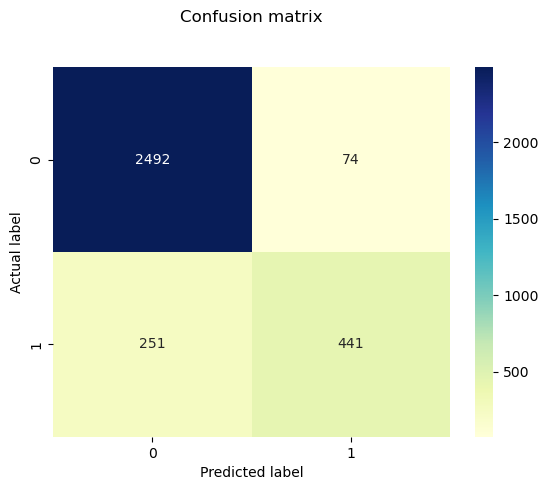

In [11]:
cm = confusion_matrix(Y_test, Y_pred_cat)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

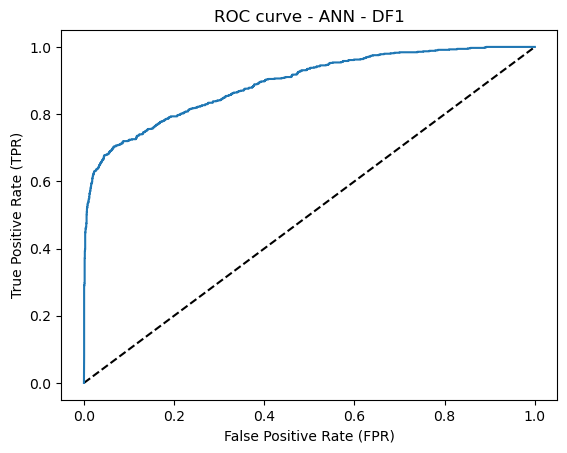

In [12]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - ANN - DF1')
plt.show()

In [13]:
#Area under ROC curve
roc_auc_score(Y_test, Y_pred)

0.8918499587761705

### <font color='indigo'>5) Hyperparameter Tuning

In [17]:
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=26, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, Y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [18]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
163/163 [==============================] - 0s 1ms/step
| 1         | 0.7805    | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.298     | 1.045     | 0.426     | 31.48     | 0.3377    | 6.935     |
163/163 [==============================] - 0s 1ms/step
| 2         | 0.7832    | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 1.932     | 1.237     | 0.08322   | 91.07     | 0.794     | 5.884     |
163/163 [==============================] - 0s 1ms/step
| 3         | 0.7805    | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.055     | 1.908     | 0.1143    | 83.55     | 0.6977    | 3.957     |
163/163 [==============================] - 0s

163/163 [==============================] - 0s 880us/step
| 16        | 0.7805    | 1.051     | 209.3     | 0.9132    | 0.1537    | 87.45     | 1.19      | 2.607     | 0.07161   | 67.19     | 0.9688    | 2.782     |
163/163 [==============================] - 0s 828us/step
| 17        | 0.6683    | 5.936     | 371.9     | 0.8899    | 0.296     | 79.09     | 2.283     | 1.504     | 0.4811    | 34.13     | 0.8683    | 1.868     |
163/163 [==============================] - 0s 758us/step
| 18        | 0.7805    | 8.757     | 370.8     | 0.2978    | 0.221     | 21.03     | 1.06      | 2.468     | 0.5033    | 29.63     | 0.00893   | 5.955     |
163/163 [==============================] - 0s 1ms/step
| 19        | 0.919     | 4.828     | 778.8     | 0.6616    | 0.2516    | 51.06     | 1.852     | 2.656     | 0.4743    | 83.8      | 0.01418   | 2.777     |
163/163 [==============================] - 0s 955us/step
| 20        | 0.5561    | 1.155     | 294.5     | 0.206     | 0.2243    | 94.41     |

In [19]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'softplus',
 'batch_size': 921,
 'dropout': 0.8182638736220813,
 'dropout_rate': 0.11976995858293202,
 'epochs': 86,
 'layers1': 1,
 'layers2': 2,
 'learning_rate': 0.4183500837466161,
 'neurons': 93,
 'normalization': 0.8253804525121795,
 'optimizer': <keras.optimizers.optimizer_v2.adagrad.Adagrad at 0x2a00d95ad60>}

### <font color='indigo'>6) Final Model

In [20]:
# Fitting Neural Network
def nn_cl_fun():
    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=26, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
        nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
        nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn
        
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)
 
nn.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/86
29/29 [==============================] - 2s 21ms/step - loss: 0.9428 - accuracy: 0.7733 - val_loss: 0.4165 - val_accuracy: 0.8109
Epoch 2/86
29/29 [==============================] - 0s 12ms/step - loss: 0.3605 - accuracy: 0.8554 - val_loss: 0.3791 - val_accuracy: 0.8431
Epoch 3/86
29/29 [==============================] - 0s 12ms/step - loss: 0.3474 - accuracy: 0.8666 - val_loss: 0.3542 - val_accuracy: 0.8585
Epoch 4/86
29/29 [==============================] - 0s 13ms/step - loss: 0.3379 - accuracy: 0.8708 - val_loss: 0.3781 - val_accuracy: 0.8793
Epoch 5/86
29/29 [==============================] - 0s 11ms/step - loss: 0.3287 - accuracy: 0.8771 - val_loss: 0.3194 - val_accuracy: 0.8763
Epoch 6/86
29/29 [==============================] - 0s 13ms/step - loss: 0.3187 - accuracy: 0.8817 - val_loss: 0.3370 - val_accuracy: 0.8849
Epoch 7/86
29/29 [==============================] - 0s 12ms/step - loss: 0.3090 - accuracy: 0.8866 - val_loss: 0.2906 - val_accuracy: 0.8996
Epoch 8/86
29

Epoch 59/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2270 - accuracy: 0.9213 - val_loss: 0.2156 - val_accuracy: 0.9251
Epoch 60/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2264 - accuracy: 0.9218 - val_loss: 0.2142 - val_accuracy: 0.9282
Epoch 61/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2259 - accuracy: 0.9222 - val_loss: 0.2198 - val_accuracy: 0.9223
Epoch 62/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2243 - accuracy: 0.9232 - val_loss: 0.2457 - val_accuracy: 0.9223
Epoch 63/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2276 - accuracy: 0.9213 - val_loss: 0.2274 - val_accuracy: 0.9220
Epoch 64/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2243 - accuracy: 0.9219 - val_loss: 0.2235 - val_accuracy: 0.9248
Epoch 65/86
29/29 [==============================] - 0s 12ms/step - loss: 0.2241 - accuracy: 0.9231 - val_loss: 0.2220 - val_accuracy: 0.9220
Epoch 

In [29]:
Y_pred_2 = nn.predict_proba(X_test)[:,1]
Y_pred_cat_2 = np.where(Y_pred_2 > 0.5, 1, 0)
target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, Y_pred_cat_2, target_names=target_names))

102/102 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

 Non-Default       0.93      0.97      0.95      2566
     Default       0.87      0.72      0.79       692

    accuracy                           0.92      3258
   macro avg       0.90      0.85      0.87      3258
weighted avg       0.92      0.92      0.92      3258



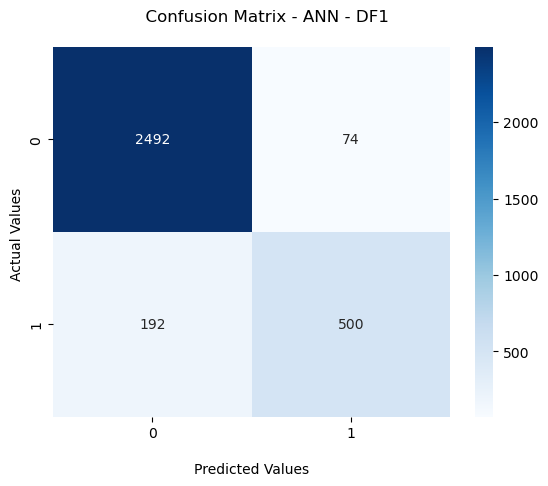

In [33]:
cm_final_model = confusion_matrix(Y_test, Y_pred_cat_2)
ax = sns.heatmap(cm_final_model, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt="d")
ax.set_title('      Confusion Matrix - ANN - DF1\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [1]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - ANN - DF1')
plt.show()

NameError: name 'roc_curve' is not defined

In [32]:
roc_auc_score(Y_test, Y_pred_2)

0.9187130280817629